Import packages

In [1]:
import numpy as np
import brian2 as b2
import matplotlib.pyplot as plt

Definitions

In [2]:
data_size = 100

n_train = 10
n_test = 20

nn = 1
ni = 1

max_spike_time = 5
train_period = 10
learning_rate = 0.5     
spread = 30  


Delay learning rule

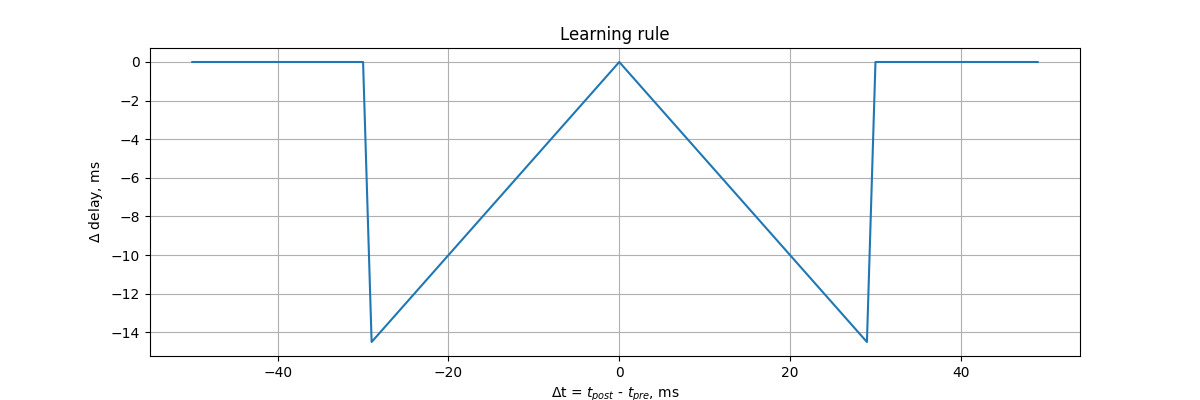

In [3]:
%matplotlib widget

def show_learning_rule(k, tmax):
    x = np.arange(-tmax-20, tmax+20)
    y = - k * abs(x) * np.heaviside(tmax - x, 0) * np.heaviside(tmax + x, 0)
    plt.figure(figsize = (12, 4))
    plt.plot(x, y)
    plt.grid()
    plt.xlabel("$\Delta$t = $t_{post}$ - $t_{pre}$, ms")
    plt.ylabel("$\Delta$ delay, ms")
    plt.title("Learning rule")

show_learning_rule(learning_rate, spread)

Model with delay learning rule

In [4]:
class SNN:
    def __init__(self, ni, train_mode=1): 

        # Input_group neurons
        #---with poisson spikes:
        # self.input_group = b2.PoissonGroup(ni, 0 * b2.Hz, name = "input_group")
        #---with spikes in equal times:
        times = [0]*ni * b2.ms
        period = train_period * b2.ms
        self.input_group = b2.SpikeGeneratorGroup(ni, list(range(ni)), times, period = period, name = "input_group")

        # Main neuron
        model_n = '''
        dv/dt = (v_rest_n - v + g_n * (E_exc_n - v)) / tau_n: volt
        tau_n : second
        vt_n : volt
        v_rest_n : volt
        v_reset_n : volt
        E_exc_n : volt
        g_n : 1
        train_mode_n : 1
        '''
        self.group_n = b2.NeuronGroup(nn, model=model_n, threshold='v>vt_n', reset='v=v_reset_n', refractory=0.1*b2.ms, method='euler')
        self.group_n.train_mode_n = train_mode
        self.group_n.tau_n = 0.7 * b2.ms     
        self.group_n.vt_n = -52 * b2.mV
        self.group_n.v_rest_n = -65 * b2.mV
        self.group_n.v_reset_n = self.group_n.v_rest_n
        self.group_n.v = self.group_n.v_rest_n
        self.group_n.g_n = 0
        self.group_n.E_exc_n = 0 * b2.mV

        # EXCISITORY synapses 
        model_e = '''
        g = g_amp * exp((tpre + shift - t) / tau_s) * int(t > tpre + shift) * int(tpre > 0 * ms) : 1
        g_n_post = g : 1 (summed)
        shift : second
        tau_s : second
        g_amp : 1
        tpre : second
        tpost : second
        train_mode_e : 1
        k : 1
        tmax : second
        ''' 
        on_pre_e = '''
        tpre = t
        '''
        on_post_e = '''
        tpost = t
        shift -= k * abs(tpost - tpre) * int(tpost - tpre < tmax) * int(-tmax < tpost - tpre)
        '''    
        self.synapses_e = b2.Synapses(self.input_group, self.group_n, model=model_e, on_pre=on_pre_e, on_post=on_post_e, method='euler')
        self.synapses_e.connect()
        self.synapses_e.train_mode_e = train_mode
        self.synapses_e.k = learning_rate     
        self.synapses_e.tmax = spread * b2.ms 
        self.synapses_e.tpost = 0 * b2.ms 
        self.synapses_e.tpre = 0 * b2.ms 
        self.synapses_e.tau_s = 0.3 * b2.ms
        self.synapses_e.g_amp = 2
        self.synapses_e.shift = max_spike_time * b2.ms 


        self.net = b2.Network(self.input_group, self.group_n, self.synapses_e)
        

Traning the model

WARNING    Cannot use Cython, a test compilation failed: Microsoft Visual C++ 14.0 or greater is required. Get it with "Microsoft C++ Build Tools": https://visualstudio.microsoft.com/visual-cpp-build-tools/ (DistutilsPlatformError) [brian2.codegen.runtime.cython_rt.cython_rt.failed_compile_test]
INFO       Cannot use compiled code, falling back to the numpy code generation target. Note that this will likely be slower than using compiled code. Set the code generation to numpy manually to avoid this message:
prefs.codegen.target = "numpy" [brian2.devices.device.codegen_fallback]


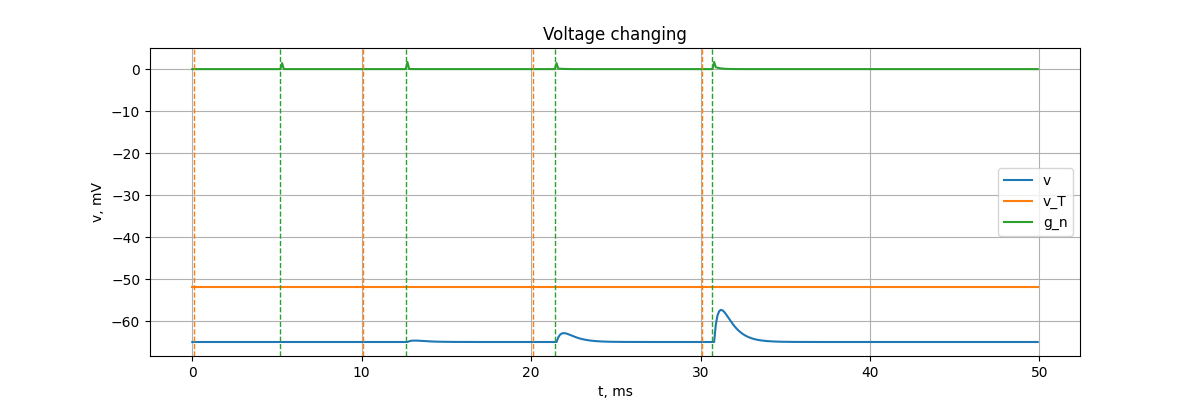

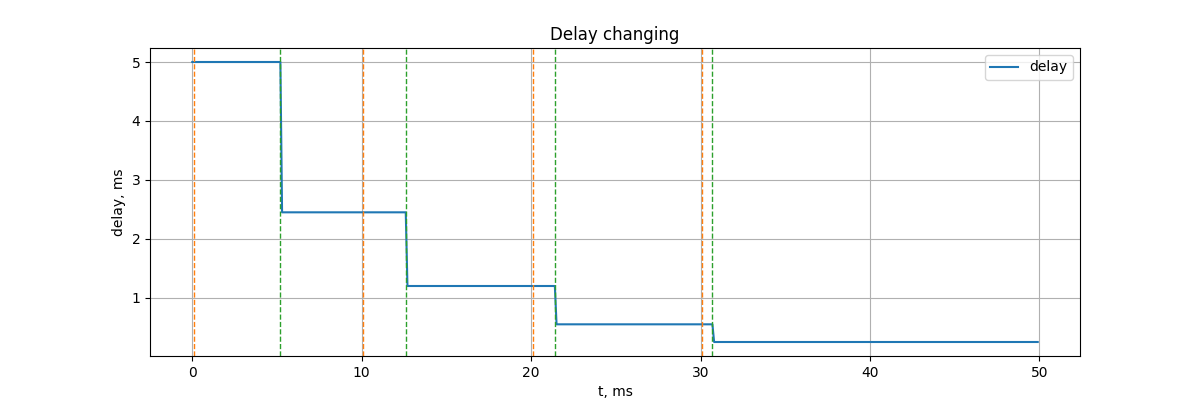

In [5]:
%matplotlib widget

def show_plots(e_state_mon, s_state_mon, i_spike_mon, e_spike_mon):

    plt.figure(figsize = (12, 4))
    plt.plot(e_state_mon.t/b2.ms, e_state_mon.v[0]/b2.mV, label='v')
    plt.plot(e_state_mon.t/b2.ms, e_state_mon.vt_n[0]/b2.mV , label='v_T')
    plt.plot(e_state_mon.t/b2.ms, e_state_mon.g_n[0] , label='g_n')
    for t in i_spike_mon.t:
        plt.axvline(t/b2.ms, ls='--', c='C1', lw=1) # orange == input
    for t in e_spike_mon.t:
        plt.axvline(t/b2.ms, ls='--', c='C2', lw=1) # green == main
    plt.legend()
    plt.grid()
    plt.xlabel("t, ms")
    plt.ylabel("v, mV")
    plt.title("Voltage changing")

    plt.figure(figsize = (12, 4))
    plt.plot(s_state_mon.t/b2.ms, s_state_mon.shift[0]/b2.ms , label='delay')
    for t in i_spike_mon.t:
        plt.axvline(t/b2.ms, ls='--', c='C1', lw=1) # orange == input
    for t in e_spike_mon.t:
        plt.axvline(t/b2.ms, ls='--', c='C2', lw=1) # green == main
    plt.legend()
    plt.grid()
    plt.xlabel("t, ms")
    plt.ylabel("delay, ms")
    plt.title("Delay changing")

snn = SNN(ni)

e_state_mon = b2.StateMonitor(snn.group_n, ['v', 'vt_n', 'g_n'], record=True)
s_state_mon = b2.StateMonitor(snn.synapses_e, ['shift'], record=True)
i_spike_mon = b2.SpikeMonitor(snn.input_group)
e_spike_mon = b2.SpikeMonitor(snn.group_n)
snn.net.add(e_state_mon)
snn.net.add(s_state_mon)
snn.net.add(i_spike_mon)
snn.net.add(e_spike_mon)

num = 1 
for i in range(num):
    #---with poisson spikes:
    # snn.input_group.rates = 200 * b2.Hz
    #---with spikes in equal times:
    snn.input_group.set_spikes([0], [0.1] * b2.ms, train_period * b2.ms)
    snn.net.run(40 * b2.ms)

    #---with poisson spikes:
    # snn.input_group.rates = 0 * b2.Hz
    #---with spikes in equal times:
    snn.input_group.set_spikes([0], [1000]*ni * b2.ms, 0 * b2.ms)
    snn.net.run(10 * b2.ms)

show_plots(e_state_mon, s_state_mon, i_spike_mon, e_spike_mon)
snn.net.remove(e_state_mon)
snn.net.remove(s_state_mon)
snn.net.remove(i_spike_mon)
snn.net.remove(e_spike_mon)
